In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
NUM_SIMULATIONS = 10000
COLORS = ("YELLOW", "BLUE", "GREEN", "RED", "BLACK", "WHITE")
COLOR_LOOKUP = {
    "YELLOW": "#BBBB77",
    "BLUE": "#77AABB",
    "GREEN": "#77BB77",
    "RED": "#BB7777",
    "BLACK": "#222222",
    "WHITE": "#B0B0B0"
}
DIE_FACES = [
    "YELLOW",
    "YELLOW",
    "YELLOW",
    "YELLOW",
    "BLUE",
    "BLUE",
    "BLUE",
    "GREEN",
    "GREEN",
    "RED",
    "BLACK",
    "WHITE"
]
NUM_DICE = 10

In [49]:
random_choices = []
for _ in range(NUM_SIMULATIONS):
    choices = np.random.choice(DIE_FACES, size=NUM_DICE)
    random_choices.append(choices)

df_random_choices = pd.DataFrame(random_choices)
df_random_choices


,0,1,2,3,4,5,6,7,8,9
0,BLACK,BLUE,WHITE,GREEN,GREEN,WHITE,GREEN,YELLOW,BLACK,GREEN
1,BLUE,YELLOW,BLUE,YELLOW,YELLOW,BLUE,BLACK,GREEN,BLUE,YELLOW
2,RED,WHITE,YELLOW,BLACK,BLUE,YELLOW,GREEN,BLUE,YELLOW,BLUE
3,BLUE,YELLOW,RED,YELLOW,YELLOW,RED,BLUE,BLUE,BLACK,YELLOW
4,YELLOW,GREEN,BLUE,GREEN,WHITE,RED,BLUE,GREEN,YELLOW,BLUE
...,...,...,...,...,...,...,...,...,...,...
9995,WHITE,YELLOW,GREEN,RED,YELLOW,GREEN,YELLOW,GREEN,BLUE,WHITE
9996,GREEN,YELLOW,YELLOW,BLACK,BLUE,BLACK,BLUE,WHITE,GREEN,YELLOW
9997,YELLOW,BLACK,GREEN,YELLOW,WHITE,BLUE,BLUE,GREEN,YELLOW,YELLOW
9998,BLUE,GREEN,YELLOW,GREEN,BLUE,YELLOW,YELLOW,YELLOW,WHITE,RED


In [50]:
yellow_distribution = df_random_choices.apply(lambda row: row.value_counts().get('YELLOW', 0), axis=1)
yellow_distribution


0       1
1       4
2       3
3       4
4       2
       ..
9995    3
9996    3
9997    4
9998    4
9999    5
Length: 10000, dtype: int64

(array([ 150.,  847., 1961., 2613., 2208., 1414.,  578.,  186.,   39.,
           4.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

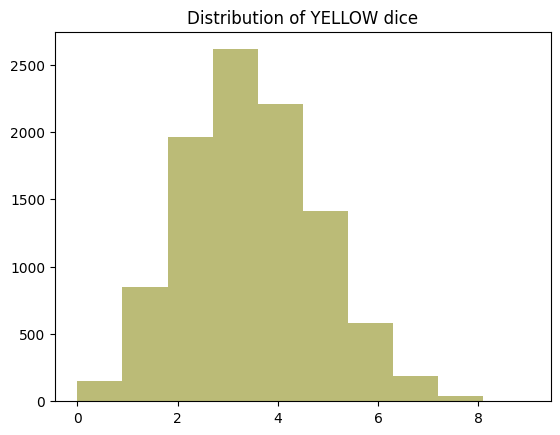

In [51]:
plt.clf()
plt.title("Distribution of YELLOW dice")
plt.hist(yellow_distribution, bins=df_random_choices.shape[1], color=COLOR_LOOKUP["YELLOW"])


<Figure size 640x480 with 0 Axes>

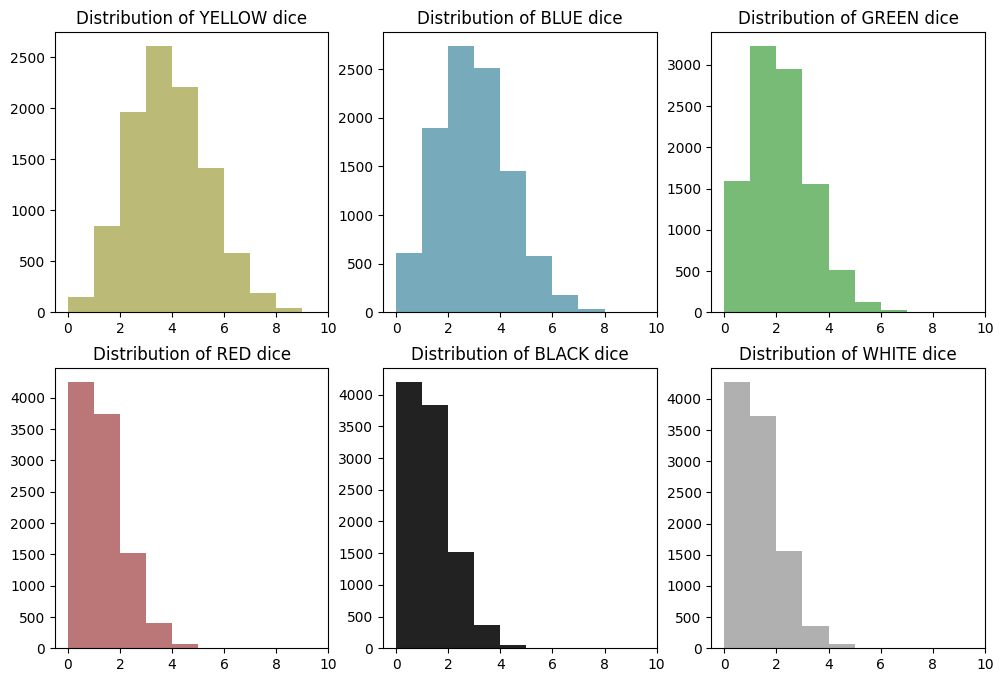

In [52]:
plt.clf()

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, color in enumerate(COLORS):
    distribution = df_random_choices.apply(lambda row: row.value_counts().get(color, 0), axis=1)
    axes[i].hist(distribution, bins=range(df_random_choices.shape[1] + 1), color=COLOR_LOOKUP[color])
    axes[i].set_title(f"Distribution of {color} dice")
    axes[i].set_xlim(right=df_random_choices.shape[1])  # Set max value on x-axis

plt.show()


In [53]:
df_by_color = df_random_choices.apply(lambda row: pd.Series(row.value_counts()).fillna(0), axis=1)
df_by_color.fillna(0, inplace=True)
df_by_color


,BLACK,BLUE,GREEN,RED,WHITE,YELLOW
0,2.0,1.0,4.0,0.0,2.0,1.0
1,1.0,4.0,1.0,0.0,0.0,4.0
2,1.0,3.0,1.0,1.0,1.0,3.0
3,1.0,3.0,0.0,2.0,0.0,4.0
4,0.0,3.0,3.0,1.0,1.0,2.0
...,...,...,...,...,...,...
9995,0.0,1.0,3.0,1.0,2.0,3.0
9996,2.0,2.0,2.0,0.0,1.0,3.0
9997,1.0,2.0,2.0,0.0,1.0,4.0
9998,0.0,2.0,2.0,1.0,1.0,4.0


In [54]:
df_black = df_by_color.pop("BLACK")
df_white = df_by_color.pop("WHITE")
df_by_color

,BLUE,GREEN,RED,YELLOW
0,1.0,4.0,0.0,1.0
1,4.0,1.0,0.0,4.0
2,3.0,1.0,1.0,3.0
3,3.0,0.0,2.0,4.0
4,3.0,3.0,1.0,2.0
...,...,...,...,...
9995,1.0,3.0,1.0,3.0
9996,2.0,2.0,0.0,3.0
9997,2.0,2.0,0.0,4.0
9998,2.0,2.0,1.0,4.0


In [55]:
df_black

0       2.0
1       1.0
2       1.0
3       1.0
4       0.0
       ... 
9995    0.0
9996    2.0
9997    1.0
9998    0.0
9999    0.0
Name: BLACK, Length: 10000, dtype: float64

In [56]:
df_white

0       2.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
9995    2.0
9996    1.0
9997    1.0
9998    1.0
9999    0.0
Name: WHITE, Length: 10000, dtype: float64

In [57]:
df_by_color = df_by_color.add(df_black, axis=0)
df_by_color


,BLUE,GREEN,RED,YELLOW
0,3.0,6.0,2.0,3.0
1,5.0,2.0,1.0,5.0
2,4.0,2.0,2.0,4.0
3,4.0,1.0,3.0,5.0
4,3.0,3.0,1.0,2.0
...,...,...,...,...
9995,1.0,3.0,1.0,3.0
9996,4.0,4.0,2.0,5.0
9997,3.0,3.0,1.0,5.0
9998,2.0,2.0,1.0,4.0


In [58]:
for color in df_by_color.columns:
    df_white_color = df_white.copy().clip(upper=df_by_color[color])
    df_by_color[color] += df_white_color

df_by_color

,BLUE,GREEN,RED,YELLOW
0,5.0,8.0,4.0,5.0
1,5.0,2.0,1.0,5.0
2,5.0,3.0,3.0,5.0
3,4.0,1.0,3.0,5.0
4,4.0,4.0,2.0,3.0
...,...,...,...,...
9995,2.0,5.0,2.0,5.0
9996,5.0,5.0,3.0,6.0
9997,4.0,4.0,2.0,6.0
9998,3.0,3.0,2.0,5.0


<Figure size 640x480 with 0 Axes>

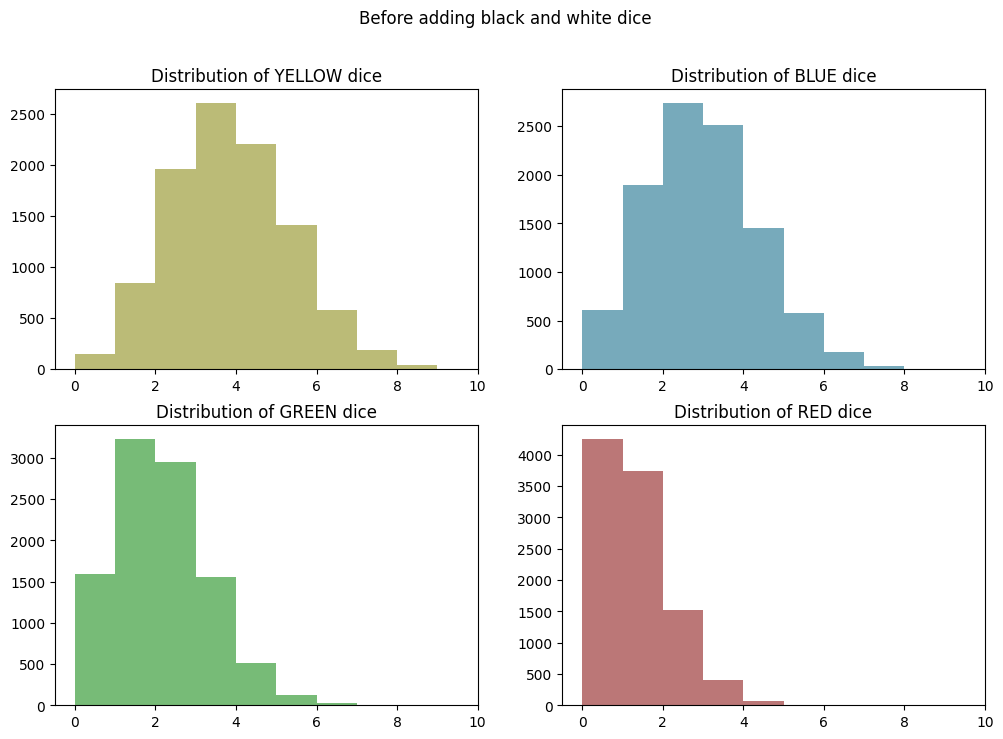

In [59]:
plt.clf()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, color in enumerate(["YELLOW", "BLUE", "GREEN", "RED"]):
    distribution = df_random_choices.apply(lambda row: row.value_counts().get(color, 0), axis=1)
    axes[i].hist(distribution, bins=range(df_random_choices.shape[1] + 1), color=COLOR_LOOKUP[color])
    axes[i].set_title(f"Distribution of {color} dice")
    axes[i].set_xlim(right=df_random_choices.shape[1])  # Set max value on x-axis

plt.suptitle("Before adding black and white dice")
plt.show()

<Figure size 640x480 with 0 Axes>

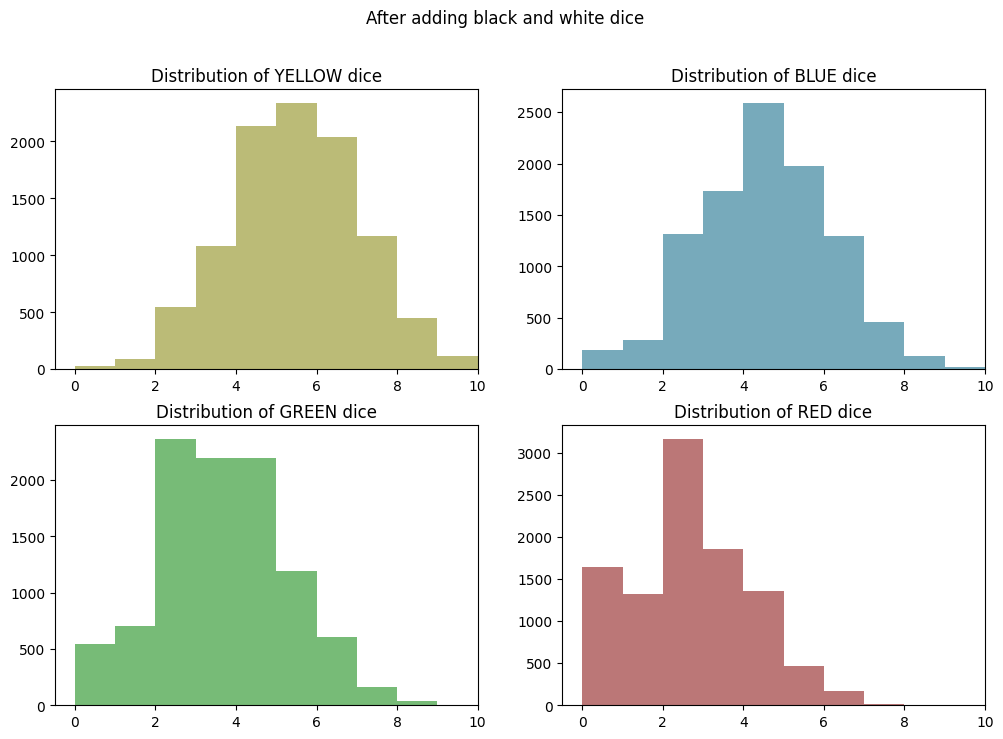

In [60]:
plt.clf()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, color in enumerate(["YELLOW", "BLUE", "GREEN", "RED"]):
    axes[i].hist(df_by_color[color], bins=range(df_random_choices.shape[1] + 1), color=COLOR_LOOKUP[color])
    axes[i].set_title(f"Distribution of {color} dice")
    axes[i].set_xlim(right=df_random_choices.shape[1])  # Set max value on x-axis

plt.suptitle("After adding black and white dice")
plt.show()
